
# Polynomial Regression — Intuition to Implementation

**Audience:** Junior undergrads / early ML learners  
**Goal:** Build intuition for polynomial regression, implement it from scratch & with scikit-learn, and learn to evaluate & regularize it.

---

## Learning Objectives

By the end of this notebook, you'll be able to:
- Explain what polynomial regression is and why/when to use it.
- Transform inputs into polynomial features and fit a linear model.
- Compare underfitting vs. overfitting visually and with metrics.
- Select the right degree using validation.
- Use regularization (Ridge/Lasso) on high-degree polynomials.
- Apply the method to a real (bundled) dataset.



## 1) Setup

We'll use `numpy`, `matplotlib`, and `scikit-learn`.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_diabetes

# For reproducibility
rng = np.random.default_rng(42)

# Matplotlib defaults (no specific colors/styles as a teaching baseline)
plt.rcParams.update({
    "figure.figsize": (6, 4),
})
print("Libraries imported successfully.")


Libraries imported successfully.



## 2) What is Polynomial Regression? (Intuition)

**Regression** predicts a continuous value (e.g., price, temperature).  
**Linear regression** fits a straight line: \( y \approx \theta_0 + \theta_1 x \).  
But many relationships are curved. **Polynomial regression** fits

\[
y \approx \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_d x^d
\]

It's **linear in parameters** (the \(\theta\)'s), but **nonlinear in the input** due to the feature transform:
\( x \to [x, x^2, x^3, \dots, x^d] \).



## 3) A Simple Synthetic Dataset

We'll create a 1D dataset where a straight line struggles, but a curved model does well.


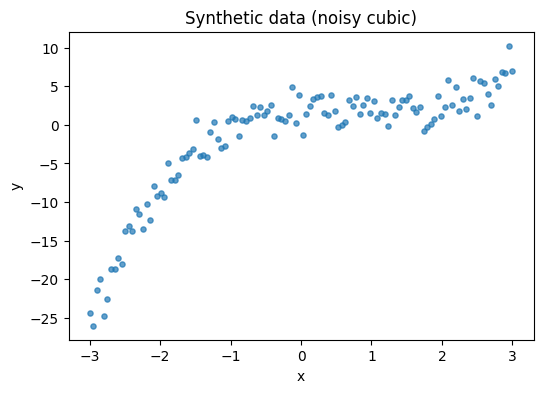

In [2]:

# Generate synthetic data from a noisy cubic curve
n = 120
X = np.linspace(-3, 3, n).reshape(-1, 1)
true_fn = lambda x: 0.5*x**3 - 1.2*x**2 + 0.9*x + 2.0
y_true = true_fn(X)
noise = rng.normal(0, 2.0, size=(n, 1))
y = (y_true + noise).ravel()

# Quick visualization
plt.scatter(X, y, s=14, alpha=0.7)
plt.title("Synthetic data (noisy cubic)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



## 4) Linear Regression Baseline

Let's first fit a **straight line** and see how it performs.


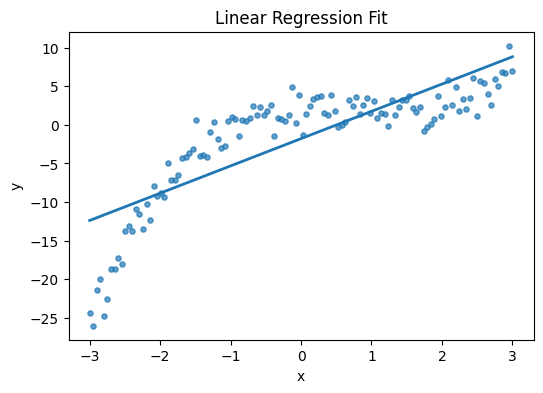

R^2 (on all data) = 0.6657908461351181
MSE (on all data) = 19.106479210895277


In [3]:

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Predictions for plotting
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred_lin = lin_reg.predict(X_plot)

plt.scatter(X, y, s=14, alpha=0.7)
plt.plot(X_plot, y_pred_lin, linewidth=2)
plt.title("Linear Regression Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print("R^2 (on all data) =", r2_score(y, lin_reg.predict(X)))
print("MSE (on all data) =", mean_squared_error(y, lin_reg.predict(X)))



## 5) Polynomial Regression: Different Degrees

We'll compare degrees **2**, **3**, and **10**.  
We'll use a `Pipeline` to chain `PolynomialFeatures` + `LinearRegression`.


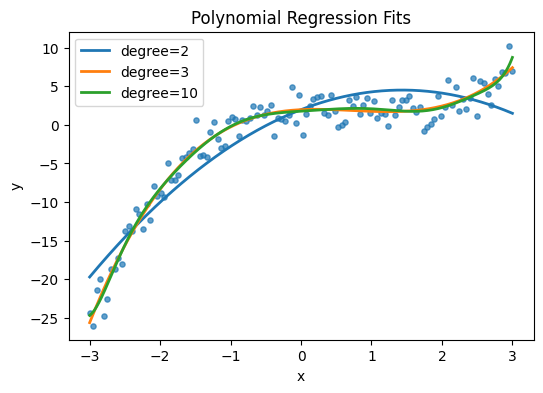

Degree  2 -> R^2=0.863 | MSE=7.848
Degree  3 -> R^2=0.959 | MSE=2.332
Degree 10 -> R^2=0.960 | MSE=2.274


In [5]:

def poly_fit_predict(X, y, degree):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X, y)
    return model, model.predict(X), model.predict(X_plot)

degrees = [2, 3, 10]
plt.scatter(X, y, s=14, alpha=0.7)
for d in degrees:
    model, y_hat, y_plot = poly_fit_predict(X, y, d)
    plt.plot(X_plot, y_plot, linewidth=2, label=f"degree={d}")
plt.title("Polynomial Regression Fits")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

for d in degrees:
    model, y_hat, _ = poly_fit_predict(X, y, d)
    print(f"Degree {d:2d} -> R^2={r2_score(y, y_hat):.3f} | MSE={mean_squared_error(y, y_hat):.3f}")



## 6) Train–Test Split & Picking the Degree

To understand **generalization**, we split data into train and test sets and evaluate on both.  
Overfitting shows up as **low train error** but **high test error**.


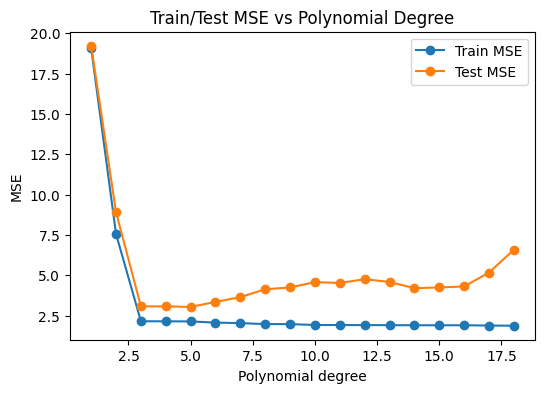

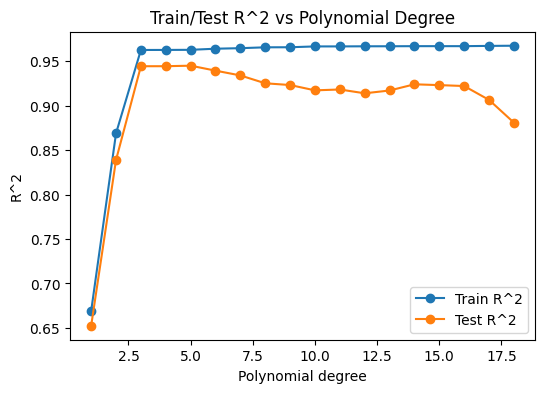

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

def evaluate_degrees(max_degree=15):
    train_mse = []
    test_mse = []
    train_r2 = []
    test_r2 = []
    degrees = range(1, max_degree+1)
    for d in degrees:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("lin", LinearRegression())
        ])
        model.fit(X_train, y_train)
        y_tr = model.predict(X_train)
        y_te = model.predict(X_test)
        train_mse.append(mean_squared_error(y_train, y_tr))
        test_mse.append(mean_squared_error(y_test, y_te))
        train_r2.append(r2_score(y_train, y_tr))
        test_r2.append(r2_score(y_test, y_te))
    return list(degrees), train_mse, test_mse, train_r2, test_r2

degrees_list, tr_mse, te_mse, tr_r2, te_r2 = evaluate_degrees(18)

# Plot MSE vs degree
plt.plot(degrees_list, tr_mse, marker="o", label="Train MSE")
plt.plot(degrees_list, te_mse, marker="o", label="Test MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Train/Test MSE vs Polynomial Degree")
plt.legend()
plt.show()

# Plot R^2 vs degree
plt.plot(degrees_list, tr_r2, marker="o", label="Train R^2")
plt.plot(degrees_list, te_r2, marker="o", label="Test R^2")
plt.xlabel("Polynomial degree")
plt.ylabel("R^2")
plt.title("Train/Test R^2 vs Polynomial Degree")
plt.legend()
plt.show()



## 7) Cross-Validation for Degree Selection

We'll use K-fold cross-validation to pick the degree that best generalizes.


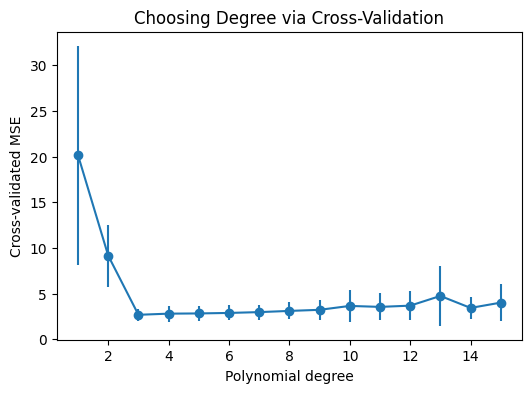

Best degree by CV (min MSE) = 3


In [7]:

def cv_score_for_degree(X, y, degree, cv=5):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    kf = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    return scores

degrees = range(1, 16)
mean_mse = []
std_mse = []
for d in degrees:
    scores = cv_score_for_degree(X, y, d, cv=5)  # negative MSE
    mean_mse.append(-scores.mean())
    std_mse.append(scores.std())

plt.errorbar(list(degrees), mean_mse, yerr=std_mse, marker="o")
plt.xlabel("Polynomial degree")
plt.ylabel("Cross-validated MSE")
plt.title("Choosing Degree via Cross-Validation")
plt.show()

best_d = list(degrees)[int(np.argmin(mean_mse))]
print("Best degree by CV (min MSE) =", best_d)



## 8) Regularization: Ridge & Lasso (Optional but Powerful)

High-degree polynomials can **overfit**. Regularization shrinks coefficients to improve generalization.

- **Ridge** adds an \(\ell_2\) penalty (squares of coefficients).
- **Lasso** adds an \(\ell_1\) penalty (absolute values), encouraging sparsity.

We'll compare unregularized LinearRegression vs. Ridge vs. Lasso for degree 15.


/home/ricky/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.671e+01, tolerance: 5.191e-01
  model = cd_fast.enet_coordinate_descent(


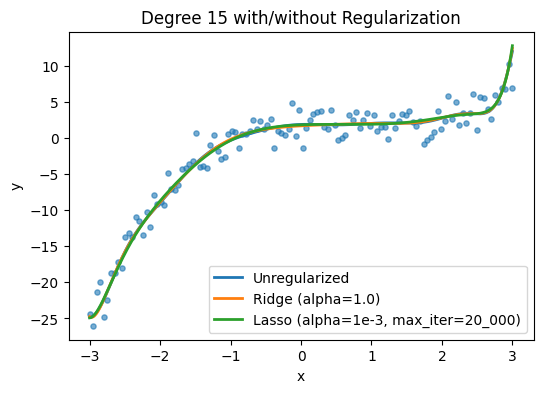

Unregularized                -> Train MSE=1.905, Test MSE=4.252
Ridge (alpha=1.0)            -> Train MSE=1.913, Test MSE=4.440
Lasso (alpha=1e-3, max_iter=20_000) -> Train MSE=1.922, Test MSE=4.622


/home/ricky/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.671e+01, tolerance: 5.191e-01
  model = cd_fast.enet_coordinate_descent(


In [8]:

degree = 15

models = {
    "Unregularized": LinearRegression(),
    "Ridge (alpha=1.0)": Ridge(alpha=1.0),
    "Lasso (alpha=1e-3, max_iter=20_000)": Lasso(alpha=1e-3, max_iter=20_000)
}

X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_train)
X_poly_test = PolynomialFeatures(degree=degree, include_bias=False).fit(X_train).transform(X_test)

X_plot_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_plot)

plt.scatter(X, y, s=14, alpha=0.6)
for name, base_model in models.items():
    base_model.fit(X_poly, y_train)
    y_plot = base_model.predict(X_plot_poly)
    plt.plot(X_plot, y_plot, linewidth=2, label=name)
plt.title(f"Degree {degree} with/without Regularization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Compare metrics
for name, base_model in models.items():
    base_model.fit(X_poly, y_train)
    y_tr = base_model.predict(X_poly)
    y_te = base_model.predict(X_poly_test)
    print(f"{name:28s} -> Train MSE={mean_squared_error(y_train, y_tr):.3f}, Test MSE={mean_squared_error(y_test, y_te):.3f}")



## 9) Real Data Example (Bundled): Diabetes Dataset

We'll use the **Diabetes** dataset bundled with scikit-learn to avoid downloads.  
To keep visualization simple, we'll fit a polynomial on **one feature** (BMI) to predict the target.  
(Using polynomials over many features is possible but increases feature count rapidly.)


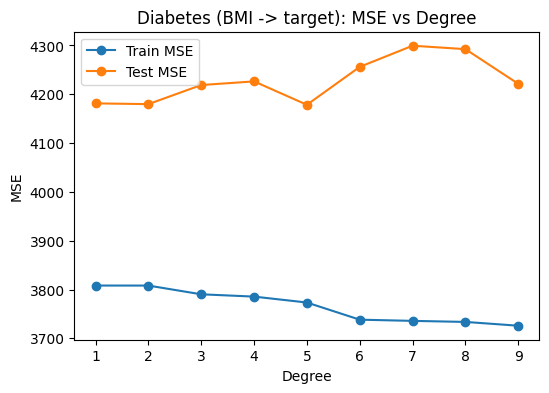

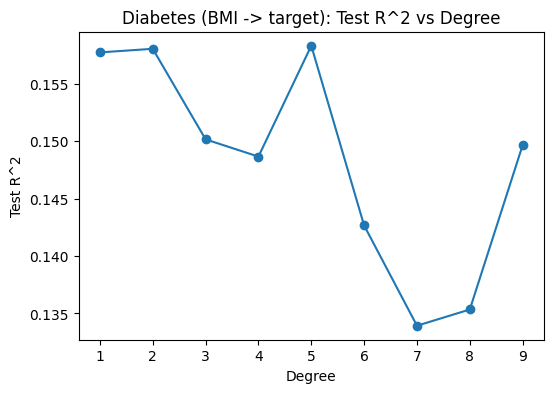

Best degree on BMI by test MSE: 5


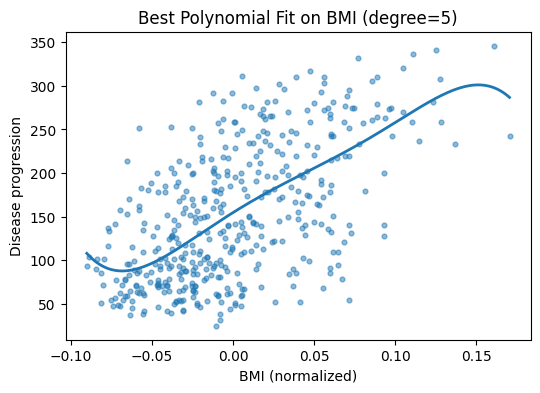

In [9]:

data = load_diabetes()
X_full = data.data
y_full = data.target
feature_names = data.feature_names

# Pick BMI feature (commonly informative)
bmi_idx = feature_names.index('bmi')
X_bmi = X_full[:, [bmi_idx]]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bmi, y_full, test_size=0.25, random_state=0)

def eval_degree_on_bmi(d):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(Xb_train, yb_train)
    yb_tr = model.predict(Xb_train)
    yb_te = model.predict(Xb_test)
    return mean_squared_error(yb_train, yb_tr), mean_squared_error(yb_test, yb_te), r2_score(yb_test, yb_te), model

degrees = range(1, 10)
train_mse, test_mse, test_r2 = [], [], []
for d in degrees:
    tr, te, r2, _ = eval_degree_on_bmi(d)
    train_mse.append(tr); test_mse.append(te); test_r2.append(r2)

plt.plot(list(degrees), train_mse, marker="o", label="Train MSE")
plt.plot(list(degrees), test_mse, marker="o", label="Test MSE")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.title("Diabetes (BMI -> target): MSE vs Degree")
plt.legend()
plt.show()

plt.plot(list(degrees), test_r2, marker="o")
plt.xlabel("Degree")
plt.ylabel("Test R^2")
plt.title("Diabetes (BMI -> target): Test R^2 vs Degree")
plt.show()

best_deg = list(degrees)[int(np.argmin(test_mse))]
print("Best degree on BMI by test MSE:", best_deg)

# Visualize best fit curve
_, _, _, best_model = eval_degree_on_bmi(best_deg)
Xb_plot = np.linspace(X_bmi.min(), X_bmi.max(), 500).reshape(-1, 1)
yb_plot = best_model.predict(Xb_plot)

plt.scatter(X_bmi, y_full, s=12, alpha=0.5)
plt.plot(Xb_plot, yb_plot, linewidth=2)
plt.xlabel("BMI (normalized)")
plt.ylabel("Disease progression")
plt.title(f"Best Polynomial Fit on BMI (degree={best_deg})")
plt.show()



## 10) (Optional) Interactive Playground

Use the slider to change the degree and see how the curve changes.  
If widgets don't render, install and enable `ipywidgets` in your environment.


In [11]:

try:
    from ipywidgets import interact, IntSlider

    @interact(degree=IntSlider(value=3, min=1, max=18, step=1, description="Degree"))
    def _interactive_poly(degree=3):
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("lin", LinearRegression())
        ])
        model.fit(X, y)
        y_plot = model.predict(X_plot)

        plt.scatter(X, y, s=14, alpha=0.7)
        plt.plot(X_plot, y_plot, linewidth=2)
        plt.title(f"Polynomial Regression (degree={degree})")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
except Exception as e:
    print("ipywidgets not available. Install with `pip install ipywidgets` if you want the interactive slider.")
    print("Error:", e)


interactive(children=(IntSlider(value=3, description='Degree', max=18, min=1), Output()), _dom_classes=('widge…


## 11) Summary & Key Takeaways

- Polynomial regression = linear regression on transformed (polynomial) features.
- Degree controls complexity: low degree → underfit; very high degree → overfit.
- Always evaluate with train/test split or cross-validation.
- Regularization (Ridge/Lasso) helps tame high-degree models.
- For multivariate inputs, `PolynomialFeatures` explodes features; use with care.

**Next steps:** Try different base functions (splines, Fourier bases, kernels) and compare.



## 12) Mini-Quiz (for your juniors)

1. Why is polynomial regression still called a *linear* model?
2. What visual/metric patterns tell you a model is overfitting?
3. How does regularization help with high-degree polynomials?
4. What are pros/cons of using polynomial features on many input variables?
5. How would you pick the degree in a principled way?

*(Answers are in the notebook above—have them justify using plots & metrics.)*



## Appendix: From Scratch (Optional)

Build the polynomial design matrix manually to demystify `PolynomialFeatures` for 1D inputs.


In [12]:

def poly_design_matrix_1d(x, degree, include_bias=False):
    x = np.asarray(x).reshape(-1, 1)
    cols = []
    start = 0 if include_bias else 1
    for p in range(start, degree+1):
        if p == 0:
            cols.append(np.ones_like(x))
        else:
            cols.append(x**p)
    return np.hstack(cols) if cols else np.ones((x.shape[0], 1))

# Check equivalence to PolynomialFeatures for 1D
deg = 4
A_manual = poly_design_matrix_1d(X, deg, include_bias=False)
A_sklearn = PolynomialFeatures(degree=deg, include_bias=False).fit_transform(X)
print("Design matrices equal?", np.allclose(A_manual, A_sklearn))


Design matrices equal? True
